# 1. Libraries and Setting
>Although the use of pre-trained models for transfer learning has achieved good results, the training of deep neural networks is very time-consuming. We hope to explore another classification method, which is to use the pre-trained model to extract the feature information of the picture, and finally try to mix multiple feature information under different models to obtain stronger feature information. Although the improvement in accuracy is very limited in the result, this process is instructive. I believe that with more diverse models and more sufficient feature information, the final accuracy rate can continue to be improved.

>In addition, due to the huge amount of data, even using the extracted features to train the classifier is very time-consuming. Therefore, we do not use cross-validation in this part, so by adjusting the parameters of the classifier, the accuracy can also be improved.

**Since we subsequently train the traditional classifiers on the extracted features in the local CPU environment and the GPU environment provided by kaggle, we need to clarify the current environment at the beginning.**

In [1]:
USE_KAGGLE = False

**In this step, we imported the commonly used libraries, set some basic parameters for subsequent use, and configured the corresponding path according to the current environment. Finally we verified the path and printed the basic structure of the data.**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#####################################
# Libraries
#####################################
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import cv2
import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# ML, statistics
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

# Tensorflow
#from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import time
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

if USE_KAGGLE == True:
    INPUT_DIR = "../input/plant-pathology-2021-fgvc8/"
    PRETRAINED_DIR = "../input/pretrained-model/"
    OUTPUT_DIR ="./"
    FEATURES_DIR = "../input/features/"
else:
    INPUT_DIR = "./plant-pathology-2021-fgvc8/"
    PRETRAINED_DIR = "./pretrained-model/"
    OUTPUT_DIR ="./working/"
    FEATURES_DIR = "./features/"
#INPUT_DIR = "../input/plant-pathology-2021-fgvc8/"
#INPUT_DIR = "./plant-pathology-2021-fgvc8/"
#INPUT_DIR = "./archive/"
#PRETRAINED_DIR = "../input/pretrained-model/"
#PRETRAINED_DIR = "./pretrained-model/"
#OUTPUT_DIR ="../working/"
#OUTPUT_DIR ="./working/"
#INPUT_DIR = "../input/plant-pathology-2021-fgvc8/"
#PRETRAINED_DIR = "../pretrained/"
#OUTPUT_DIR = "./model/"


TRAIN_DATA_DIR = INPUT_DIR + 'train_images'
#TRAIN_DATA_DIR = INPUT_DIR + 'img_sz_256'
#TRAIN_DATA_DIR = INPUT_DIR + 'img_sz_512'


IMSIZES = (224, 240, 260, 300, 380, 456, 528, 600)

NUM_CLASSES = 12
IMAGE_SIZE= (224,224)  #(256,256)

BATCH_SIZE = 16 #32  16
TRAIN_BATCH_SIZE = 512 #512 256
#16，512 works

print(os.listdir(OUTPUT_DIR))
print(os.listdir(INPUT_DIR))

toy=False

all_df = pd.read_csv(INPUT_DIR + "train.csv")
if toy:
    all_df = all_df.sample(5000)


NB_TRAIN = all_df.shape[0]  #15930 #4275 #32706
NB_VALID = NB_TRAIN * 0.1 #1770 #475 #10902

print(all_df.shape)
all_df.head()

['best_EfficientNetB7.h5', 'best_XceptionDenseNet121.h5']
['sample_submission.csv', 'test_images', 'train.csv', 'train_images']
(18632, 2)


,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


# 2. DataPreparation

**First, the data set is divided into a training set and a test set to facilitate the calculation of accuracy locally.**

(17700, 2)


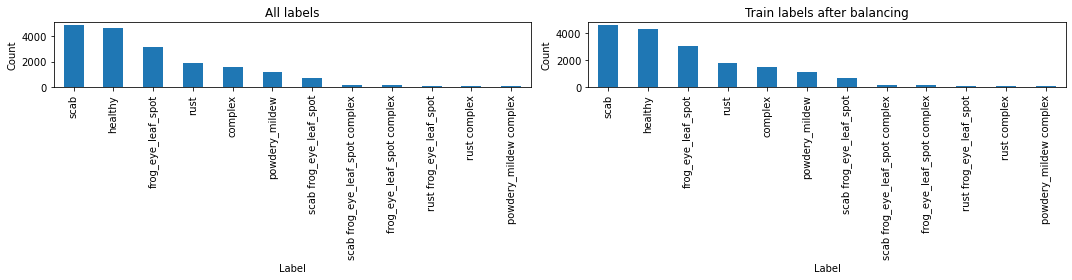

(18632, 2) (17700, 2) (932, 2)


In [3]:
class DataPreparation:
    """
    Train/test
    """
    def train_test_split(self, all_df):
        """
        Balanced split to train, test and val
        """
        # Split to train and test before balancing
        train_df, test_df = train_test_split(all_df, random_state=24, test_size=0.05, shuffle=False)
        print(train_df.shape)
#         # Split train to train and validation datasets
#         train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=24)
        # Number of samples in each category
        
        #ncat_bal = train_df['labels'].value_counts().max()
#        #ncat_bal = int(len(train_df)/train_df['label'].cat.categories.size)
        #train_df = train_df.groupby('labels', as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True, random_state=24)).reset_index(drop=True)
        #print(train_df.shape, ncat_bal)
        return train_df, test_df
    
    def plot_balanced(self, train_df, all_df):
        """
        Plot samples per category before and after balancing
        """
        f, axs = plt.subplots(1,2,figsize=(15,4))
        # Before balancing
        all_df.labels.value_counts().plot(kind='bar', ax=axs[0])
        axs[0].set_title('All labels')
        axs[0].set_xlabel('Label')
        axs[0].set_ylabel('Count')
        # After balancing
        train_df.labels.value_counts().plot(kind='bar', ax=axs[1])
        axs[1].set_title('Train labels after balancing')
        axs[1].set_xlabel('Label')
        axs[1].set_ylabel('Count')
        plt.tight_layout()
        plt.show()


# Train/test/validation split with balanced labels in train
data_prep = DataPreparation()
train_df, test_df = data_prep.train_test_split(all_df)

# Plot before and after balancing
data_prep.plot_balanced(train_df, all_df)
print(all_df.shape,train_df.shape, test_df.shape)

**After that, we created the Generators class, which contains a basic ImageDataGenerator to implement basic data augmentation. On this basis, we inherited it and used flow_from_dataframe() to obtain three subset generators. They read in the data in the form of batches and preprocessed them for output. This is very friendly for memory management when the amount of data is large.**

In [4]:
class Generators:
    """
    Train, validation and test generators
    """
    def __init__(self, train_df, test_df):
        self.batch_size= BATCH_SIZE #16 #1024 #32 #8
        self.img_size= IMAGE_SIZE #(256,256)#(512,512)#(192,128) #(96,64) (384,256)  #(4000,2672)

        # Base train/validation generator
        _datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.1,
            #featurewise_center=False,
            #featurewise_std_normalization=False,
            fill_mode='nearest',
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10, #180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.15, # Randomly zoom image 
            width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True  # randomly flip images
            )
 
        # Train generator
        self.train_generator = _datagen.flow_from_dataframe(
            dataframe=train_df, #all_df, #
            directory=TRAIN_DATA_DIR,
            x_col="image",
            y_col="labels",
            #has_ext=False,
            
            subset="training",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False, #True,
            class_mode="categorical",
            target_size=self.img_size)
        print('Train generator created')
        # Validation generator
        self.val_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,#test_df ,#
            directory=TRAIN_DATA_DIR,
            x_col="image",
            y_col="labels",
            #has_ext=False,
            
            subset="validation",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False, #True,
            class_mode="categorical",
            target_size=self.img_size)    
        print('Validation generator created')
        
        
        # Test generator
        _test_datagen=ImageDataGenerator(rescale=1./255.)
        self.test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=TRAIN_DATA_DIR,
            x_col="image",
            y_col='labels',
            #has_ext=False,
            class_mode="categorical",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False,
            target_size=self.img_size)     
        print('Test generator created')

        
        
        
# Create generators   
#(43608, 2) (4658, 2)
generators = Generators(train_df, test_df)
print("Generators created")

Found 15930 validated image filenames belonging to 12 classes.
Train generator created
Found 1770 validated image filenames belonging to 12 classes.
Validation generator created
Found 932 validated image filenames belonging to 12 classes.
Test generator created
Generators created


# 3. Generate Features
>In this part, we first specify the required pre-training model and remove the classification layer to obtain our feature generator. Then we use the Generators class created earlier to read in the data in batch size, expand the dimensions, call the preprocessing method of the corresponding model, and finally generate features for each picture and save it with the list. It is worth noting that since we do not use the validation set in this part, the validation set and the training set are merged.

In [5]:
import tensorflow.keras.applications.vgg16 as vgg16
import tensorflow.keras.applications.resnet_v2 as resnet_v2
import tensorflow.keras.applications.densenet as densenet
import tensorflow.keras.applications.inception_resnet_v2 as inception_resnet_v2
import tensorflow.keras.applications.xception as xception
import tensorflow.keras.applications.mobilenet_v2 as mobilenet_v2
import tensorflow.keras.applications.efficientnet as efficientnet
import xgboost as xgb
from numpy import logspace
from scipy import stats


#efficientnet.EfficientNetB7
#mobilenet_v2.MobileNetV2
#xception.Xception
#densenet.DenseNet121
#resnet_v2.ResNet50V2
#vgg16.VGG16
#inception_resnet_v2.InceptionResNetV2

pre_trained_model = densenet
pre_trained_model_type = densenet.DenseNet121
pre_trained_model_type_name = 'DenseNet121'

if USE_KAGGLE == True:
    path = PRETRAINED_DIR + 'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
    cls_model_f = pre_trained_model_type(weights=path,
                              include_top=False, # remove the classification layer
                              pooling='avg', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
else:
    cls_model_f = pre_trained_model_type(weights='imagenet',
                              include_top=False, # remove the classification layer
                              pooling='avg', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

classes_2 = ['complex', 'frog_eye_leaf_spot', 'frog_eye_leaf_spot complex', 'healthy', 
             'powdery_mildew', 'powdery_mildew complex', 'rust', 'rust complex', 'rust frog_eye_leaf_spot', 
             'scab', 'scab frog_eye_leaf_spot', 'scab frog_eye_leaf_spot complex']
def get_class_2(one_hot):
    for i in range(NUM_CLASSES):
        if one_hot[i] == 1:
            return classes_2[i]
def get_class_index(one_hot):
    for i in range(NUM_CLASSES):
        if one_hot[i] == 1:
            return i

In [6]:
trainX_fea = []
testX_fea = []
trainY_cls = []
testY_cls = []

In [7]:
#15930 , 1770, 932
train_set_len = int(train_df.shape[0]*0.9)
val_set_len = int(train_df.shape[0]*0.1)
test_set_len = test_df.shape[0]

In [9]:
# By using subset, train_generator just get 15930 images
#train_iternum = train_set_len//16
#val_iternum = val_set_len//16
train_iternum = train_set_len//BATCH_SIZE
val_iternum = val_set_len//BATCH_SIZE


#train_set
for i in range(train_iternum):
    print(i)
    img_batch, label_batch = generators.train_generator.next()
    for j in range(len(img_batch)):
        img_batch[j] = tf.expand_dims(img_batch[j], axis=0) 
        img_batch[j] = pre_trained_model.preprocess_input(img_batch[j])

    tmp = cls_model_f.predict(img_batch)
    for j in range(len(tmp)):
        trainX_fea.append(tmp[j])
        
    for j in range(len(label_batch)):
        trainY_cls.append(get_class_index(label_batch[j]))

img_batch, label_batch = generators.train_generator.next()
for j in range(len(img_batch)):
    img_batch[j] = tf.expand_dims(img_batch[j], axis=0) 
    img_batch[j] = pre_trained_model.preprocess_input(img_batch[j])

tmp = cls_model_f.predict(img_batch)
for j in range(train_set_len - BATCH_SIZE*train_iternum):
    trainX_fea.append(tmp[j])

for j in range(train_set_len - BATCH_SIZE*train_iternum):
    trainY_cls.append(get_class_index(label_batch[j]))
    
    
#val_set   
for i in range(val_iternum):
    print(i)
    img_batch, label_batch = generators.val_generator.next()
    for j in range(len(img_batch)):
        img_batch[j] = tf.expand_dims(img_batch[j], axis=0) 
        img_batch[j] = pre_trained_model.preprocess_input(img_batch[j])

    tmp = cls_model_f.predict(img_batch)
    for j in range(len(tmp)):
        trainX_fea.append(tmp[j])
        
    for j in range(len(label_batch)):
        trainY_cls.append(get_class_index(label_batch[j]))

img_batch, label_batch = generators.val_generator.next()
for j in range(len(img_batch)):
    img_batch[j] = tf.expand_dims(img_batch[j], axis=0) 
    img_batch[j] = pre_trained_model.preprocess_input(img_batch[j])

tmp = cls_model_f.predict(img_batch)
for j in range(val_set_len - BATCH_SIZE*val_iternum):
    trainX_fea.append(tmp[j])

for j in range(val_set_len - BATCH_SIZE*val_iternum):
    trainY_cls.append(get_class_index(label_batch[j]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
print(len(trainX_fea[0]))
print(len(trainX_fea))

print(max(trainY_cls))
print(len(trainY_cls))

1024
17700
11
17700


**Save the obtained features as npy files for subsequent use.**

In [12]:
trainX_fea_save = np.asarray(trainX_fea).reshape(len(trainX_fea),len(trainX_fea[0]))
#np.save("EfficientNetB7_train.npy",trainX_fea_save)
np.save(OUTPUT_DIR + pre_trained_model_type_name + '_train.npy',trainX_fea_save)                                                
                                                 

trainY_cls_save = np.asarray(trainY_cls).reshape(len(trainY_cls), 1)
#np.save("EfficientNetB7_train_label.npy",trainY_cls_save)
np.save(OUTPUT_DIR + pre_trained_model_type_name + '_train_label.npy',trainY_cls_save)

**Perform similar operations on the test set.**

In [13]:
test_iternum = test_set_len//BATCH_SIZE

for i in range(test_iternum):
    print(i)
    img_batch, label_batch = generators.test_generator.next()
    for j in range(len(img_batch)):
        img_batch[j] = tf.expand_dims(img_batch[j], axis=0) 
        img_batch[j] = pre_trained_model.preprocess_input(img_batch[j])

    tmp = cls_model_f.predict(img_batch)
    for j in range(len(tmp)):
        testX_fea.append(tmp[j])
        
    for j in range(len(label_batch)):
        testY_cls.append(get_class_index(label_batch[j]))
        
img_batch, label_batch = generators.test_generator.next()
for j in range(len(img_batch)):
    img_batch[j] = tf.expand_dims(img_batch[j], axis=0) 
    img_batch[j] = pre_trained_model.preprocess_input(img_batch[j])

tmp = cls_model_f.predict(img_batch)
for j in range(test_set_len - BATCH_SIZE*test_iternum):
    testX_fea.append(tmp[j])

for j in range(test_set_len - BATCH_SIZE*test_iternum):
    testY_cls.append(get_class_index(label_batch[j]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


In [14]:
print(len(testX_fea[0]))
print(len(testX_fea))

print(max(testY_cls))
print(len(testY_cls))

1024
932
11
932


In [15]:
testX_fea_save = np.asarray(testX_fea).reshape(len(testX_fea),len(testX_fea[0]))
#np.save("EfficientNetB7_test.npy",testX_fea_save)
np.save(OUTPUT_DIR + pre_trained_model_type_name + '_test.npy',testX_fea_save)  

testY_cls_save = np.asarray(testY_cls).reshape(len(testX_fea), 1)
#np.save("EfficientNetB7_test_label.npy",testY_cls_save)
np.save(OUTPUT_DIR + pre_trained_model_type_name + '_test_label.npy',testY_cls_save) 

# 4. Load features and Classify!
>In this part, we will read in the previously saved features and use various classifiers to verify the strength of each basic feature. It is worth noting that in the GPU environment, we can use the cuml library provided by NVIDIA RAPIDS to greatly accelerate the training of some classifiers. The default version provided by Kaggle is 0.16.0, and we upgraded it to 0.19.0 by using the installation package.

In [16]:
#Get the new version RAPIDS from https://www.kaggle.com/cdeotte/rapids as input dataset
if USE_KAGGLE == True:
    import sys
    !cp ../input/rapids/rapids.0.19.0 /opt/conda/envs/rapids.tar.gz
    !cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
    sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
    sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
    sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
    !cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [17]:
if USE_KAGGLE == True:
    import cuml
    from cuml import linear_model
    from cuml import multiclass
    from cuml import svm
    from cuml import naive_bayes
    from cuml import decomposition
    from cuml.ensemble import RandomForestClassifier as cuRFC
    
    cuml.__version__ 
else:
    from sklearn import linear_model
    from sklearn import ensemble
    from sklearn import svm
    from sklearn import multiclass
    from sklearn import model_selection
    from sklearn import decomposition

In [18]:
modelname_basic = 'DenseNet121'

trainX_fea = np.load(FEATURES_DIR + modelname_basic + '_train.npy')
trainY_cls = np.load(FEATURES_DIR + modelname_basic + '_train_label.npy')
testX_fea = np.load(FEATURES_DIR + modelname_basic + '_test.npy')
testY_cls = np.load(FEATURES_DIR + modelname_basic + '_test_label.npy')

print(trainX_fea.shape)
print(trainY_cls.shape)
print(testX_fea.shape)
print(testY_cls.shape)

(17700, 1024)
(17700, 1)
(932, 1024)
(932, 1)


**LogisticRegression(ovr)**

In [19]:
#Linear
if USE_KAGGLE == True:
    mlogreg = multiclass.MulticlassClassifier(linear_model.LogisticRegression(C=10, max_iter = 4000, class_weight='balanced'), strategy='ovr')
    mlogreg.fit(trainX_fea, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = mlogreg.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))
else:
    mlogreg = linear_model.LogisticRegression(C=10, multi_class='ovr', max_iter = 4000)
    mlogreg.fit(trainX_fea, trainY_cls.reshape(trainY_cls.shape[0], ))

    print("w=", mlogreg.coef_)
    print("b=", mlogreg.intercept_)

    predY_cls = mlogreg.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))

w= [[-1.89293594e-03  3.97013816e-03 -1.25525868e-02 ... -7.59595669e-02
  -3.33544949e-01  0.00000000e+00]
 [ 6.02692917e-04  1.14744023e-02  2.62183365e-02 ... -1.86018805e+00
  -2.10830529e+00  0.00000000e+00]
 [-8.28956477e-04 -3.37922942e-03 -6.34308808e-03 ... -7.26137848e-01
   2.76851845e-01  0.00000000e+00]
 ...
 [ 2.66660862e-03 -3.11443841e-02 -2.37306661e-02 ...  2.35038847e+00
   2.05615798e+00  0.00000000e+00]
 [-8.70609423e-04 -4.04474289e-03 -1.77807382e-02 ...  2.62880080e-03
  -5.09319605e-01  0.00000000e+00]
 [-3.93536739e-04 -7.11250158e-03 -9.13027781e-04 ...  1.74625555e-01
   1.53672134e+00  0.00000000e+00]]
b= [ -1.07084558   2.48664938   0.11678925 -65.7266658   -2.2191831
   0.14819038  34.15634207  -0.36417588   0.38297077   0.78384914
  -0.71826212  -0.85939503]
val accuracy = 0.4592274678111588


**LogisticRegression(multinomial)**

In [ ]:
if USE_KAGGLE == True:
    mlogreg_2 = multiclass.MulticlassClassifier(linear_model.LogisticRegression(C=10, max_iter = 4000, class_weight='balanced'), strategy='ovo')
    mlogreg_2.fit(trainX_fea, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = mlogreg_2.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))
else:
    mlogreg_2 = linear_model.LogisticRegression(C=10, multi_class='multinomial', max_iter = 4000)
    mlogreg_2.fit(trainX_fea, trainY_cls.reshape(trainY_cls.shape[0], ))

    print("w=", mlogreg_2.coef_)
    print("b=", mlogreg_2.intercept_)

    predY_cls = mlogreg_2.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))

**MultinomialNB**

In [ ]:
if USE_KAGGLE == True:
    mnbclf = naive_bayes.MultinomialNB(alpha=0.1)
    mnbclf.fit(trainX_fea, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = mnbclf.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))

**OneVsRestClassifier(linear-svm)**

In [ ]:
if USE_KAGGLE == True:
    msvm = multiclass.OneVsRestClassifier(svm.SVC(kernel='linear'))
    msvm.fit(trainX_fea, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = msvm.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))
else:
    msvm = multiclass.OneVsRestClassifier(svm.SVC(kernel='linear'))
    msvm.fit(trainX_fea, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = msvm.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))

**RBF-svm**

In [ ]:
#Non-Linear
if USE_KAGGLE == True:
    rbfsvm = svm.SVC(kernel='rbf', gamma='scale', C=1000)
    rbfsvm.fit(trainX_fea, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = rbfsvm.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))
else:
    rbfsvm = svm.SVC(kernel='rbf', gamma=0.1, C=1000)
    rbfsvm.fit(trainX_fea, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = rbfsvm.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))

**AdaBoostClassifier(n_estimators=300)**

In [ ]:
if USE_KAGGLE == False:
    ada=ensemble.AdaBoostClassifier(learning_rate=0.1, n_estimators=300, random_state=4487)
    ada.fit(trainX_fea, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = ada.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))

**XGBClassifier(n_estimators=300)**

In [ ]:
if USE_KAGGLE == False:
    xgbclf = xgb.XGBClassifier(objective="multi:softprob", learning_rate=0.1, n_estimators=300, random_state=4487)
    xgbclf.fit(trainX_fea, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = xgbclf.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))

**RandomForestClassifier(n_estimators=2000) or RandomForestClassifier(n_estimators=1000)**

In [ ]:
if USE_KAGGLE == True:
    rfclf = cuRFC(n_estimators=1000, random_state=4487)
    rfclf.fit(trainX_fea,trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = rfclf.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))
else:
    rfclf = ensemble.RandomForestClassifier(n_estimators=2000, random_state=4487, n_jobs=-1)
    rfclf.fit(trainX_fea, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = rfclf.predict(testX_fea)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))

**The accuracy of the above classifier under each basic feature is as follows:**
![results_1_cuml](../asserts/results_1_cuml.jpg)

# 5. Features Fusion and PCA
>In the last part, we try to mix different basic features before making a selection. From the previous results, we know that DenseNet121, Xception and MobileNetV2 perform relatively well. We concatenate them and use the PCA of different n_components to select and get new features. And use the previous classifiers that performed well for training, and the results are as follows:
![results_2_cuml](../asserts/results_2_cuml.jpg)

In [20]:
#mobilenet_v2.MobileNetV2
#xception.Xception
#densenet.DenseNet121
#resnet_v2.ResNet50V2
#vgg16.VGG16
#inception_resnet_v2.InceptionResNetV2
modelname1 = 'DenseNet121'
modelname2 = 'Xception'
modelname3 = 'MobileNetV2'
PCA_n_components = 2048

# feature fusion
feature1 = np.load(FEATURES_DIR + modelname1 + '_train.npy')
feature2 = np.load(FEATURES_DIR + modelname2 + '_train.npy')
feature3 = np.load(FEATURES_DIR + modelname3 + '_train.npy')
new_feature = np.concatenate((feature1, feature2, feature3), axis=1)
#new_feature = np.concatenate((feature1, feature2), axis=1)
print(new_feature.shape)

test_feature1 = np.load(FEATURES_DIR + modelname1 + '_test.npy')
test_feature2 = np.load(FEATURES_DIR + modelname2 + '_test.npy')
test_feature3 = np.load(FEATURES_DIR + modelname3 + '_test.npy')
new_test_feature = np.concatenate((test_feature1, test_feature2, test_feature3), axis=1)
#new_test_feature = np.concatenate((test_feature1, test_feature2), axis=1)
print(new_test_feature.shape)

# feature selection
pca = decomposition.PCA(n_components=PCA_n_components)
W = pca.fit_transform(new_feature)
test_W = pca.transform(new_test_feature)
print(W.shape)
print(test_W.shape)

(17700, 4352)
(932, 4352)
(17700, 2048)
(932, 2048)


In [21]:
np.save(OUTPUT_DIR + modelname1+'_'+modelname2+'_'+modelname3+'_PCA'+str(PCA_n_components) + "_train.npy",W)
np.save(OUTPUT_DIR + modelname1+'_'+modelname2+'_'+modelname3+'_PCA'+str(PCA_n_components) + "_test.npy",test_W)

In [ ]:
if USE_KAGGLE == True:
    msvm = multiclass.OneVsRestClassifier(svm.SVC(kernel='linear'))
    msvm.fit(W, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = msvm.predict(test_W)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))
else:
    msvm = multiclass.OneVsRestClassifier(svm.SVC(kernel='linear'))
    msvm.fit(W, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = msvm.predict(test_W)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))

In [ ]:
if USE_KAGGLE == True:
    rbfsvm = svm.SVC(kernel='rbf', gamma='scale', C=1000)
    rbfsvm.fit(W, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = rbfsvm.predict(test_W)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))
else:
    rbfsvm = svm.SVC(kernel='rbf', gamma=0.1, C=1000)
    rbfsvm.fit(W, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = rbfsvm.predict(test_W)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))

In [22]:
if USE_KAGGLE == True:
    rfclf = cuRFC(n_estimators=1000, random_state=4487)
    rfclf.fit(W,trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = rfclf.predict(test_W)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))
else:
    rfclf = ensemble.RandomForestClassifier(n_estimators=2000, random_state=4487, n_jobs=-1)
    rfclf.fit(W, trainY_cls.reshape(trainY_cls.shape[0], ))

    predY_cls = rfclf.predict(test_W)
    acc = metrics.accuracy_score(testY_cls, predY_cls)
    print("val accuracy = " + str(acc))

val accuracy = 0.36802575107296137


**Under the same classifier, the best accuracy of the new feature is increased by 0.466738197 from the basic feature's 0.465665236, although this improvement is not obvious. But by adding more basic features (such as extracting more features from the middle layer of the pre-trained model), the accuracy may continue to improve.**
![results_3_cuml](../asserts/results_3_cuml.jpg)